# About
This notebook shall investigate the mixture of odds
- based on the current season's win & losses
- historical NCAA wins & losses
***

# Preface
## Imports

In [45]:
import os
os.chdir("/home/jovyan/work")

from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from sqlalchemy import text

from src.utils import calc_odds, evaluate_log_loss, get_connection

## Config

In [2]:
%matplotlib inline
sns.set()
HTML("""
<style>
.output_png{
text-align:center;
}
</style>
""")

***
# Get enhanced regular season data

In [3]:
df_ncaa_results_wins_losses_regular_season = pd.read_sql(
    sql=text("""
SELECT
ncaa.season as season,
ncaa.w_team_id as team_id_a,
wins_a.wins as wins_a,
losses_a.losses as losses_a,
ncaa.l_team_id as team_id_b,
wins_b.wins as wins_b,
losses_b.losses as losses_b
FROM t_original_ncaa_tourney_compact_results ncaa

-- join info about winning team
JOIN t_derived_wins_per_team_per_season wins_a
    ON ncaa.w_team_id = wins_a.team_id
    AND ncaa.season = wins_a.season
    
JOIN t_derived_losses_per_team_per_season losses_a
    ON ncaa.w_team_id = losses_a.team_id
    AND ncaa.season = losses_a.season
    
-- join info about losing team
JOIN t_derived_wins_per_team_per_season wins_b
    ON ncaa.l_team_id = wins_b.team_id
    AND ncaa.season = wins_b.season
    
JOIN t_derived_losses_per_team_per_season losses_b
    ON ncaa.l_team_id = losses_b.team_id
    AND ncaa.season = losses_b.season
    """),
    con=get_connection()
)
df_ncaa_results_wins_losses_regular_season.head()

,season,team_id_a,wins_a,losses_a,team_id_b,wins_b,losses_b
0,1985,1116,21,12,1234,20,10
1,1985,1120,18,11,1345,17,8
2,1985,1207,25,2,1250,11,18
3,1985,1229,20,7,1425,19,9
4,1985,1242,23,7,1325,20,7


# Get odds for regular season

In [4]:
df_odds_regular_season = calc_odds(df_ncaa_results_wins_losses_regular_season, 100, 100)
df_odds_regular_season.head()

,season,team_id_a,wins_a,losses_a,team_id_b,wins_b,losses_b,odds_a
0,1985,1116,21,12,1234,20,10,0.3986
1,1985,1120,18,11,1345,17,8,0.3141
2,1985,1207,25,2,1250,11,18,1.0000
3,1985,1229,20,7,1425,19,9,0.7029
4,1985,1242,23,7,1325,20,7,0.5869


# Get enhanced historic season data

In [5]:
df_ncaa_results_wins_losses_historical = pd.read_sql(
    sql=text("""
SELECT
ncaa.season as season,
ncaa.w_team_id as team_id_a,
wins_a.wins as wins_a,
losses_a.losses as losses_a,
ncaa.l_team_id as team_id_b,
wins_b.wins as wins_b,
losses_b.losses as losses_b
FROM t_original_ncaa_tourney_compact_results ncaa

-- join info about winning team
JOIN t_derived_ncaa_wins_per_team wins_a
    ON ncaa.w_team_id = wins_a.team_id
    
JOIN t_derived_ncaa_losses_per_team losses_a
    ON ncaa.w_team_id = losses_a.team_id
    
-- join info about losing team
JOIN t_derived_ncaa_wins_per_team wins_b
    ON ncaa.l_team_id = wins_b.team_id
    
JOIN t_derived_ncaa_losses_per_team losses_b
    ON ncaa.l_team_id = losses_b.team_id
    """),
    con=get_connection()
)
df_ncaa_results_wins_losses_historical.head()

,season,team_id_a,wins_a,losses_a,team_id_b,wins_b,losses_b
0,1985,1116,30,18,1234,16,17
1,1985,1120,12,7,1345,28,24
2,1985,1207,33,21,1250,1,5
3,1985,1229,2,4,1425,9,12
4,1985,1242,80,30,1325,3,5


# Get odds for historic season

In [6]:
df_odds_historical = calc_odds(df_ncaa_results_wins_losses_historical, 100, 100)
df_odds_historical.head()

,season,team_id_a,wins_a,losses_a,team_id_b,wins_b,losses_b,odds_a
0,1985,1116,30,18,1234,16,17,0.8975
1,1985,1120,12,7,1345,28,24,0.7662
2,1985,1207,33,21,1250,1,5,0.9872
3,1985,1229,2,4,1425,9,12,0.3155
4,1985,1242,80,30,1325,3,5,0.9776


# Join historic and regular season odd

In order to improve the prediction via win/loss odds, the regular seasons odds shall be joined with the historic ncaa odds.

In [25]:
df_odds_merged = pd.merge(
    df_odds_historical[["season", "team_id_a", "team_id_b", "odds_a"]],
    df_odds_regular_season[["season", "team_id_a", "team_id_b", "odds_a"]],
    on = ["season", "team_id_a", "team_id_b"],
    suffixes = ("_historical", "_regular")
)

# Evaluate the joint odd distribution

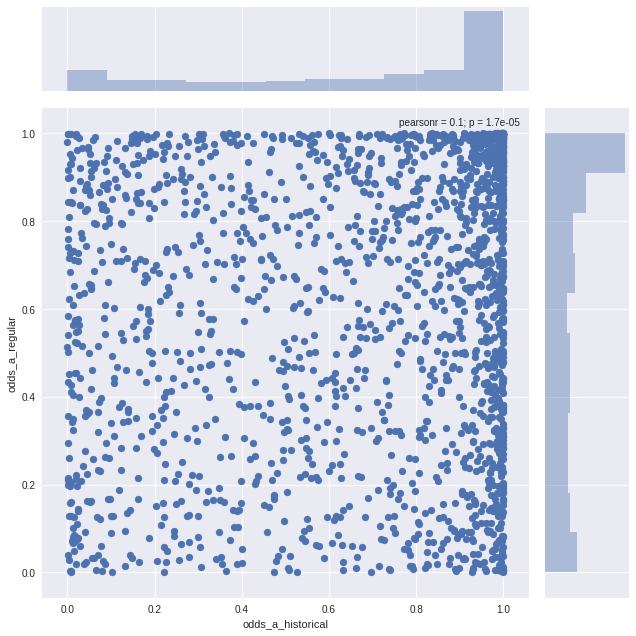

In [24]:
sns.jointplot(x=df_odds_merged["odds_a_historical"], y=df_odds_merged["odds_a_regular"],size=9);
#plt.savefig("./figures/04_jgoerner_regular_historical_odds_mixed.png");

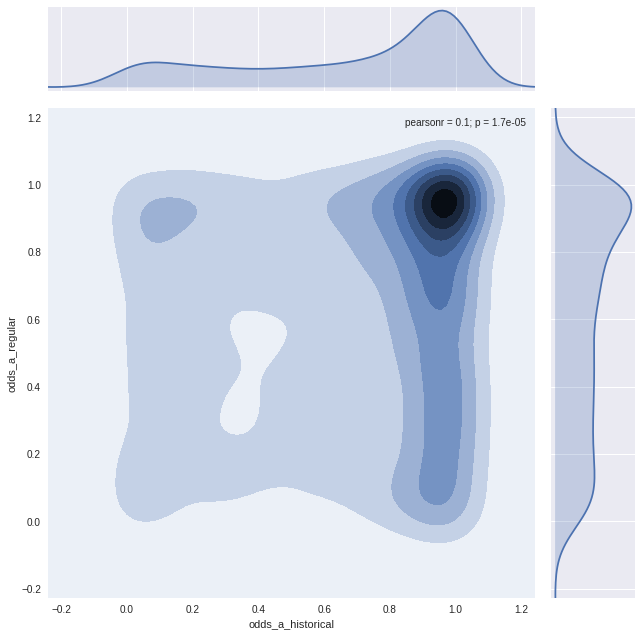

In [8]:
sns.jointplot(x=df_odds_merged["odds_a_historical"], y=df_odds_merged["odds_a_regular"],size=9, kind="kde");
#plt.savefig("./figures/04_jgoerner_regular_historical_odds_mixed_kde.png");

# Blend the odd distributions
One attempt to combine the regular season odds with the historical ncaa odds is to combine the number of wins / number of losses to get a new beta distribution. Based on that distribution further sampling can be made.

In [34]:
df_joined_wins_losses = pd.merge(
    df_odds_historical,
    df_odds_regular_season,
    on = ["season", "team_id_a", "team_id_b"],
    suffixes = ("_historical", "_regular")
)
df_joined_wins_losses.head()

,season,team_id_a,wins_a_historical,losses_a_historical,team_id_b,wins_b_historical,losses_b_historical,odds_a_historical,wins_a_regular,losses_a_regular,wins_b_regular,losses_b_regular,odds_a_regular
0,1985,1116,30,18,1234,16,17,0.8975,21,12,20,10,0.3986
1,1985,1120,12,7,1345,28,24,0.7662,18,11,17,8,0.3141
2,1985,1207,33,21,1250,1,5,0.9872,25,2,11,18,1.0000
3,1985,1229,2,4,1425,9,12,0.3155,20,7,19,9,0.7029
4,1985,1242,80,30,1325,3,5,0.9776,23,7,20,7,0.5869


Combine regular season wins & historic ncaa wins (losses respectively):

In [52]:
df_joined_wins_losses["wins_a"] = df_joined_wins_losses["wins_a_historical"] + df_joined_wins_losses["wins_a_regular"]
df_joined_wins_losses["losses_a"] = df_joined_wins_losses["losses_a_historical"] + df_joined_wins_losses["losses_a_regular"]
df_joined_wins_losses["wins_b"] = df_joined_wins_losses["wins_b_historical"] + df_joined_wins_losses["losses_b_historical"]
df_joined_wins_losses["losses_b"] = df_joined_wins_losses["losses_b_historical"] + df_joined_wins_losses["losses_b_regular"]

Calculate odds based on the combined wins & losses.

In [56]:
df_joined_wins_losses = calc_odds(
    df_tmp,
    N_SAMPLE=100, 
    N_EXPERIMENT=100)

Evaluate the overall distribution of blended odds:

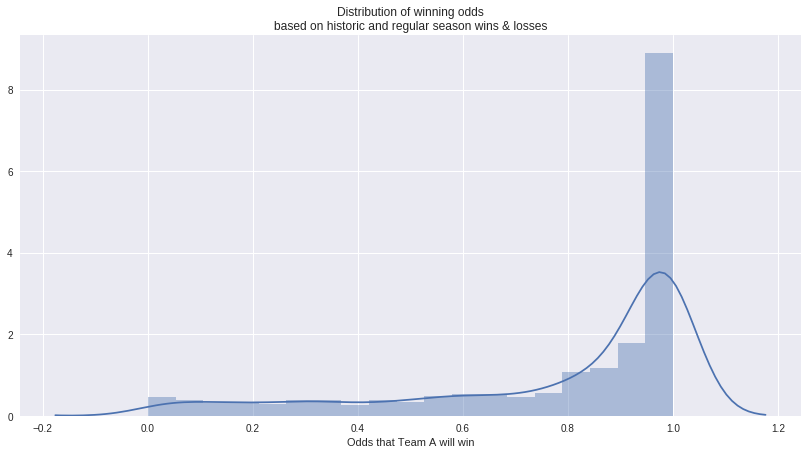

In [57]:
plt.rcParams["figure.figsize"] = (14, 7)
sns.distplot(df_joined_wins_losses["odds_a"])
plt.title("Distribution of winning odds\nbased on historic and regular season wins & losses")
plt.xlabel("Odds that Team A will win");
#plt.savefig("./figures/04_jgoerner_regular_historical_odds_mixed_odd_distribution.png");

Compared to the distribution of the solely regular season odds / historic ncaa odds, the odds of the mixed distribution seem to put stronger emphasis on the higher odds (which causes a decrease of the log-loss). The following figure shows that situation:

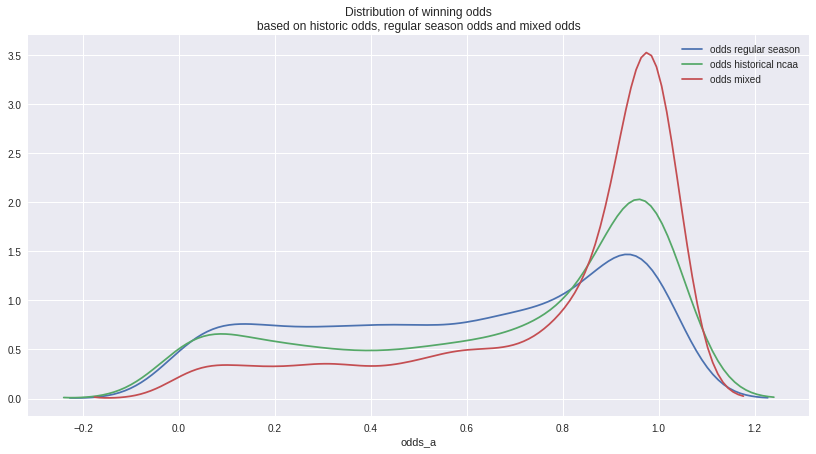

In [71]:
sns.distplot(df_joined_wins_losses["odds_a_regular"], hist=False, label="odds regular season")
sns.distplot(df_joined_wins_losses["odds_a_historical"], hist=False, label="odds historical ncaa")
sns.distplot(df_joined_wins_losses["odds_a"], hist=False, label="odds mixed")
plt.title("Distribution of winning odds\nbased on historic odds, regular season odds and mixed odds");
#plt.savefig("./figures/04_jgoerner_regular_historical_odds_mixed_odd_comparison.png");